In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["denoised_trace", "std_phon_trace", "phonetic_trace","fourier_coeffs"]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

## Import

In [5]:
df = pd.read_csv(DF_PREPROC_FILE)

traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"))


In [6]:
len(traces["fourier_coeffs"][0])

32

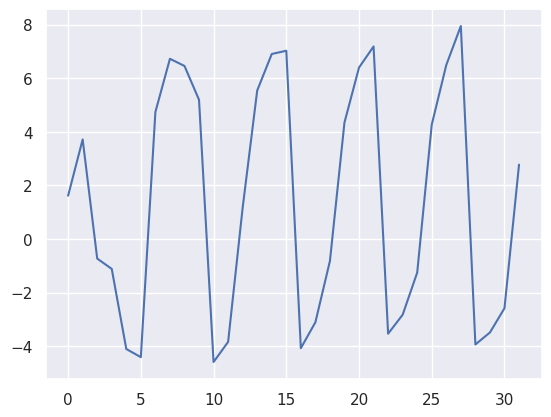

In [7]:
plt.plot(traces["fourier_coeffs"][0])

## Metrics

In [8]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [9]:
mat_euclidean = cdist(traces["fourier_coeffs"],traces["fourier_coeffs"])

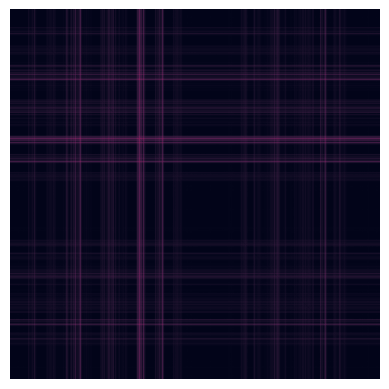

In [10]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

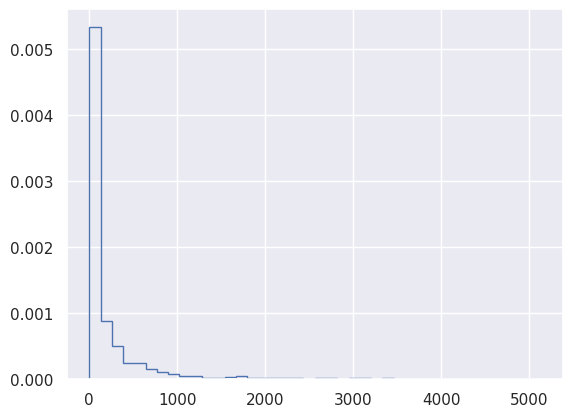

In [11]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);

### Manhattan

In [15]:
mat_manhattan = cdist(traces["fourier_coeffs"],traces["fourier_coeffs"], metric="cityblock")

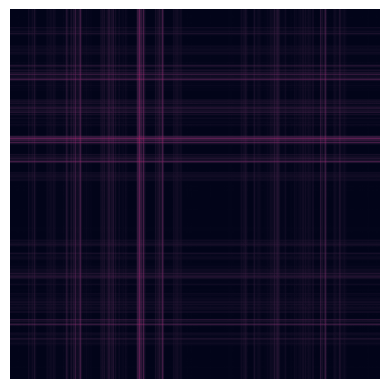

In [16]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

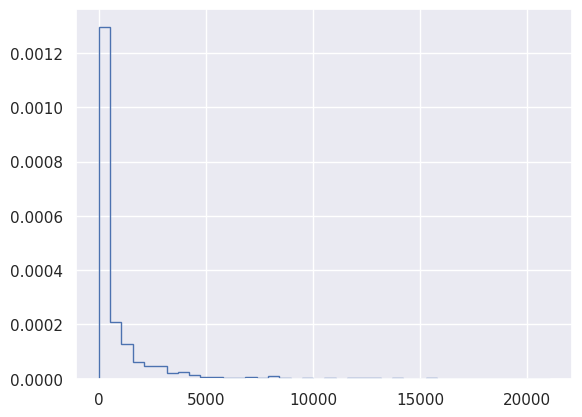

In [17]:
# Distribution of distances
distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [12]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

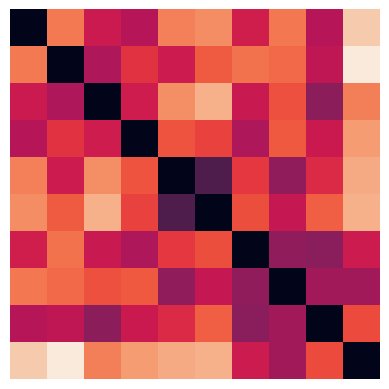

In [13]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


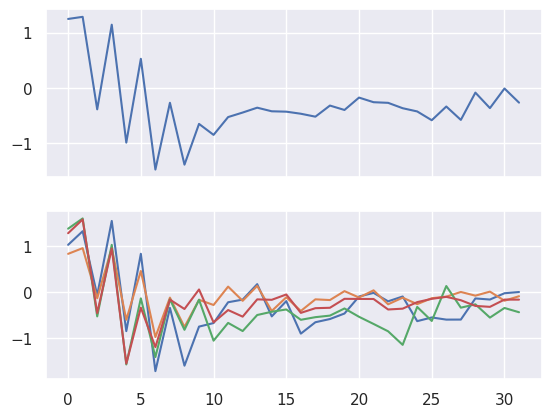

In [18]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(traces["fourier_coeffs"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True)

# Plot the requested query
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [15]:
X_train.shape

(2206, 745)

## Kmeans

### Euclidean

79564.633 --> 74022.692 --> 71246.332 --> 69952.069 --> 68978.921 --> 67801.939 --> 65935.402 --> 65668.248 --> 65573.685 --> 65536.293 --> 65526.899 --> 65526.899 --> 


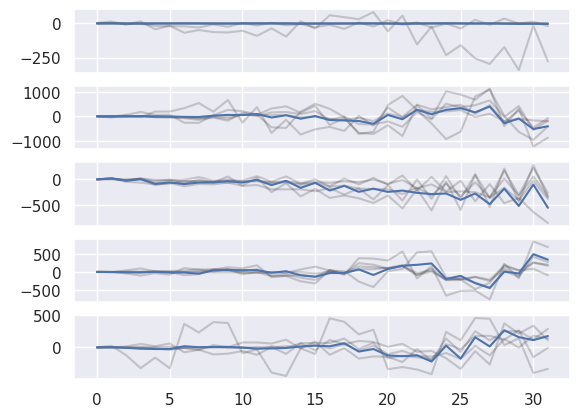

In [20]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 5

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = km.fit_predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(n_clusters):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])

### DTW

In [24]:
n_clusters = 5

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

y_pred = km.fit_predict(X_train)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))
y_pred = km.predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2206 out of 2206 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=

45045.694 --> 

KeyboardInterrupt: 